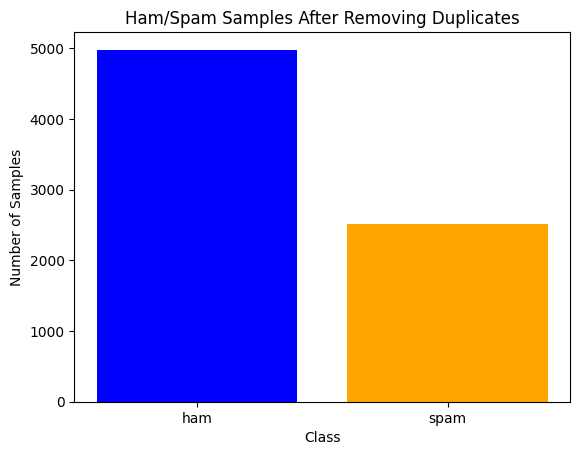

Found 4981 images belonging to 2 classes.
Found 1244 images belonging to 2 classes.


/Users/ivan/miniconda/lib/python3.10/site-packages/keras/preprocessing/image.py:202: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(
/var/folders/zk/fp362p395194brg_nb832d9h0000gn/T/ipykernel_88077/2898357953.py:180: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = KerasClassifier(build_fn=build_model, callbacks=[early_stopping], verbose=0)
2023-05-29 01:20:16.644305: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 66s 7s/step - loss: 0.6029 - accuracy: 0.7508
Validation accuracy: 0.7508038878440857
Validation loss: 0.6029346585273743
47/47 [==============================] - 2s 37ms/step


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not array(['spam', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype='<U4')

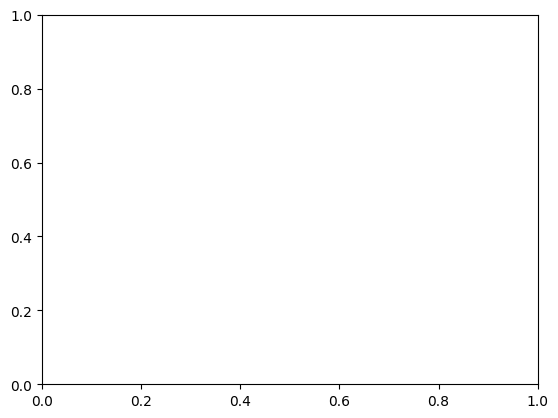

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import imagehash
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define constants
DATA_DIR = 'dataset/images'
IMG_SIZE = (256, 256)
EPOCHS = 1
BATCH_SIZE = 128
SEED = 42
DROPOUT_RATE = 0.5
LR = 0.001

def remove_alpha_channel(image):
    """Remove the alpha channel from an image."""
    if image.mode != 'RGBA':
        return image
    canvas = Image.new('RGBA', image.size, (255,255,255,255))
    canvas.paste(image, mask=image)
    return canvas.convert('RGB')

def preprocess_image(hashfunc, hash_size=8):
    """Preprocess an image by removing the alpha channel and applying a hash function."""
    def function(path):
        image = remove_alpha_channel(Image.open(path))
        image = image.convert("L").resize((hash_size, hash_size), Image.LANCZOS)
        data = image.getdata()
        quantiles = np.arange(100)
        quantiles_values = np.percentile(data, quantiles)
        zdata = (np.interp(data, quantiles_values, quantiles) / 100 * 255).astype(np.uint8)
        image.putdata(zdata)
        return hashfunc(image)
    return function

def remove_duplicate_images(data_dir):
    """Remove duplicate images from a directory."""
    hash_dict = {}
    dhash_z_transformed = preprocess_image(imagehash.dhash, hash_size = 8)
    for class_dir in ['ham', 'spam']:
        class_path = Path(data_dir) / class_dir
        for image_path in class_path.iterdir():
            hash = dhash_z_transformed(image_path)
            if hash not in hash_dict:
                hash_dict[hash] = image_path
            else:
                print(f"Removing duplicate image: {image_path}")
                image_path.unlink()
    return hash_dict

def plot_class_distribution(hash_dict):
    """Plot the distribution of classes in the dataset."""
    ham_count = sum(1 for image_hash in hash_dict.values() if "ham" in str(image_hash))
    spam_count = sum(1 for image_hash in hash_dict.values() if "spam" in str(image_hash))
    plt.bar(["ham", "spam"], [ham_count, spam_count], color=["blue", "orange"])
    plt.title("Ham/Spam Samples After Removing Duplicates")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.show()

def create_data_generators(data_dir, img_size):
    """Create data generators for training and validation data."""
    data_augmentation = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=lambda x: tf.image.resize_with_pad(x, target_height=img_size[0], target_width=img_size[1]))

    train_data_generator = data_augmentation.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        subset='training',
        seed=SEED)

    val_data_generator = data_augmentation.flow_from_directory(
        data_dir, 
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed=SEED)

    return train_data_generator, val_data_generator

def build_model():
    """Build and compile the model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def load_data(data_dir):
    """Load the image data and labels."""
    X = []
    y = []

    for dir in os.listdir(data_dir):
        for filename in os.listdir(os.path.join(data_dir, dir)):
            img = load_img(os.path.join(data_dir, dir, filename), target_size=IMG_SIZE)
            img = img_to_array(img)
            img = preprocess_input(img)
            X.append(img)
            y.append(dir)

    return np.array(X), np.array(y)

def plot_results(X_train, X_test, y_train, y_test, predictions):
    """Plot the results of the model."""
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label='Train', s=10)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', label='Test', s=10)
    plt.xlabel("Email Length")
    plt.ylabel("Keyword Presence")
    plt.title("Scatter Plot of Ham and Spam Samples")
    plt.legend()
    plt.show()

    conf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print(classification_report(y_test, predictions))

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def main():
    """Main function to control the flow of the program."""
    hash_dict = remove_duplicate_images(DATA_DIR)
    plot_class_distribution(hash_dict)
    train_data_generator, val_data_generator = create_data_generators(DATA_DIR, IMG_SIZE)

    model = build_model()
    early_stopping = EarlyStopping(monitor='loss', patience=3)
    keras_clf = KerasClassifier(build_fn=build_model, callbacks=[early_stopping], verbose=0)

    X, y = load_data(DATA_DIR)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    history = model.fit(train_data_generator, epochs=EPOCHS, validation_data=val_data_generator)
    model.save('image_spam_classification_model.h5')

    score, acc = model.evaluate(val_data_generator)
    print('Validation accuracy:', acc)
    print('Validation loss:', score)

    predictions = (model.predict(X_test) > 0.5).astype('int32')
    plot_results(X_train, X_test, y_train, y_test, predictions)

if __name__ == "__main__":
    main()
